In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/y_test_0_10_256.npy
/kaggle/input/X_test_10_20_256.npy
/kaggle/input/Postdam_0_20_256_UNet_50epochs_M_focal.hdf5
/kaggle/input/X_train_10_20_256.npy
/kaggle/input/y_train_10_20_256.npy
/kaggle/input/X_test_0_10_256.npy
/kaggle/input/Postdam_10_20_256_UNet_50epochs_M_focal.hdf5
/kaggle/input/y_test_10_20_256.npy
/kaggle/input/X_train_0_10_256.npy
/kaggle/input/y_train_0_10_256.npy


In [2]:
First10Images=np.load("/kaggle/input/X_test_10_20_256.npy",allow_pickle=True)


## Optimized version of performance

EnhancedPyTorchOCLAHE initialized on device: cpu
Converting to grayscale...
Processing image with shape: (256, 256)
Grid: 8x8 tiles of size 32x32
Created LUT and binned image
Created histograms
Clipped histograms with dynamic clip limits
Calculated CDF maps
Applied interpolation
Core processing time (cpu): 0.1545 seconds
Total apply time (cpu): 0.2208 seconds


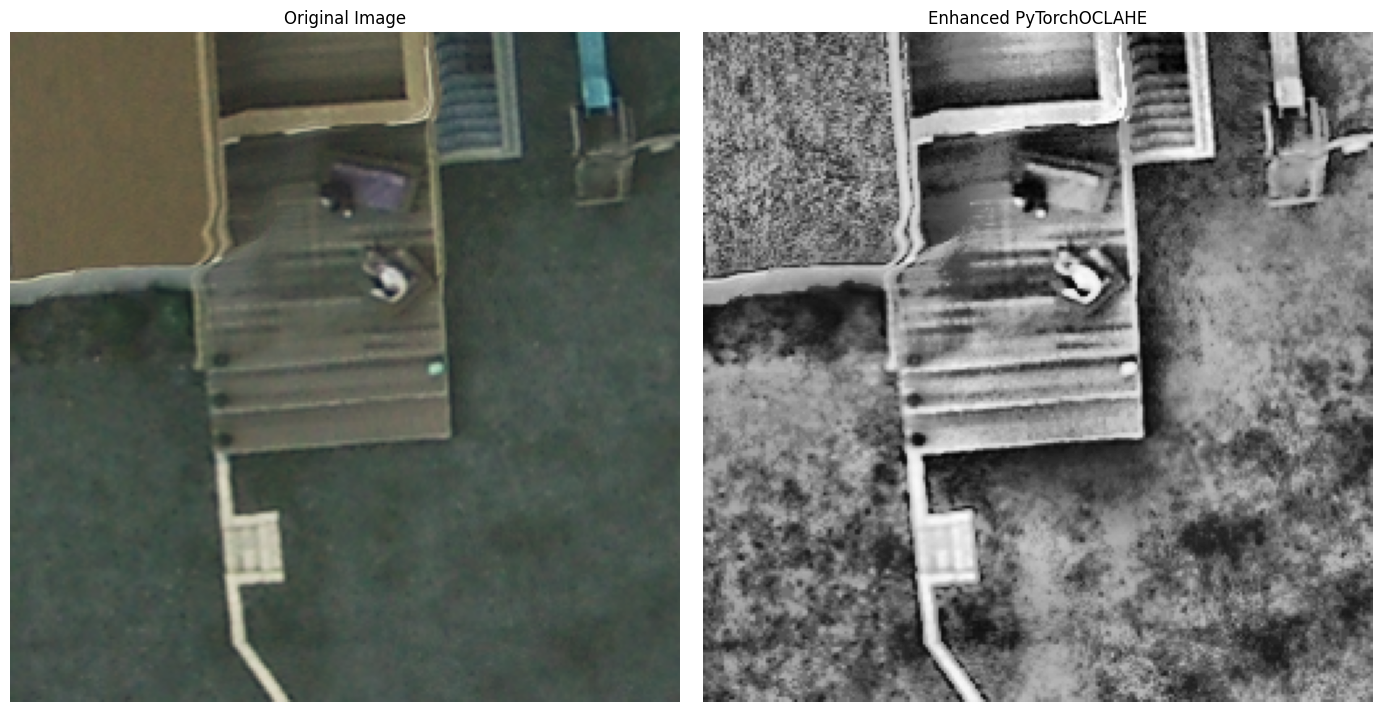

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Union
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, Optional, Union, List, Any

class EnhancedPyTorchOCLAHE:
    """
    Optimized PyTorch implementation of O_CLAHE algorithm with dynamic clip limit.
    
    This implementation provides:
    - GPU acceleration when available
    - Fully vectorized operations for maximum performance
    - Performance optimizations from TerOCLAHE
    - Output quality of the original PyTorchOCLAHE
    
    Attributes:
    -----------
    device : torch.device
        Device to perform computations on (CPU or GPU)
    """
    
    def __init__(self, 
                 num_bins: int = 128,
                 target_tile_size: Tuple[int, int] = (32, 32),
                 use_gpu: bool = True,
                 max_val: int = 255,
                 min_val: int = 0):
        """
        Initialize the Enhanced PyTorch O_CLAHE processor.
        
        Parameters:
        -----------
        num_bins : int, optional
            Number of histogram bins (default: 128)
        target_tile_size : Tuple[int, int], optional
            Target size for contextual regions (default: (32, 32))
        use_gpu : bool, optional
            Whether to use GPU if available (default: True)
        max_val : int, optional
            Maximum pixel value (default: 255)
        min_val : int, optional
            Minimum pixel value (default: 0)
        """
        # Use GPU if requested and available
        self.device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
        
        # Configuration parameters
        self.num_bins = num_bins
        self.target_tile_size = target_tile_size
        self.max_val = max_val
        self.min_val = min_val
        self.num_pixels_per_tile = 0  # Will be set during processing
        
        print(f"EnhancedPyTorchOCLAHE initialized on device: {self.device}")
    
    def _find_outliers_IQR(self, data: torch.Tensor) -> torch.Tensor:
        """
        Find outliers in data using the Interquartile Range (IQR) method.
        
        Parameters:
        -----------
        data : torch.Tensor
            Input data tensor to check for outliers
            
        Returns:
        --------
        torch.Tensor
            Tensor containing only the outlier values
        """
        q1 = torch.quantile(data, 0.25)
        q3 = torch.quantile(data, 0.75)
        iqr = q3 - q1
        
        # Identify outliers
        mask = (data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))
        outliers = data[mask]
        
        return outliers
    
    
    def _dynamic_clip_limit(self, hist_tensor: torch.Tensor) -> float:
        """
        Determine dynamic clip limit based on histogram outliers.
        Maintains the same algorithm as PyTorchOCLAHE but optimized.
        
        Parameters:
        -----------
        hist_tensor : torch.Tensor
            Histogram for defined contextual region
            
        Returns:
        --------
        float
            Dynamic clip limit value
        """
        if hist_tensor.numel() == 0:
            return float(self.num_pixels_per_tile + 1)
            
        # Find outliers
        outliers = self._find_outliers_IQR(hist_tensor)
        
        # If no outliers, use a high limit (effectively no clipping)
        if outliers.numel() == 0:
            return float(self.num_pixels_per_tile + 1)
            
        # Calculate mean of outliers
        mo = outliers.mean().item()
        
        # Get histogram values without outliers
        min_outlier = outliers.min().item()
        wo_mask = hist_tensor <= min_outlier
        wo = hist_tensor[wo_mask]
        
        # Calculate mean of non-outlier values
        d = 0.0
        if wo.numel() > 0:
            d = wo.mean().item()
        
        # Calculate final limit
        limit = mo + d
        return max(0.0, float(limit))
    
    def _calculate_grid_params(self, img_height: int, img_width: int) -> Tuple[int, int, int, int, tuple, int]:
        """
        Calculate grid parameters for tiling.
        Adapted from TerOCLAHE for efficiency.
        
        Parameters:
        -----------
        img_height : int
            Height of the input image
        img_width : int
            Width of the input image
            
        Returns:
        --------
        Tuple[int, int, int, int, tuple, int]
            num_tiles_y, num_tiles_x, tile_h, tile_w, padding, pad_y
        """
        tile_h, tile_w = self.target_tile_size
        tile_h = max(1, tile_h)
        tile_w = max(1, tile_w)
        
        num_tiles_y = (img_height + tile_h - 1) // tile_h
        num_tiles_x = (img_width + tile_w - 1) // tile_w
        
        num_tiles_y = max(1, num_tiles_y)
        num_tiles_x = max(1, num_tiles_x)
        
        padded_h = tile_h * num_tiles_y
        padded_w = tile_w * num_tiles_x
        pad_y = padded_h - img_height
        pad_x = padded_w - img_width
        padding = (0, pad_x, 0, pad_y)
        
        self.num_pixels_per_tile = tile_h * tile_w
        
        return num_tiles_y, num_tiles_x, tile_h, tile_w, padding, pad_y
    
    def _create_lut(self) -> torch.Tensor:
        """
        Create lookup table for bin assignments.
        Vectorized implementation from TerOCLAHE.
        
        Returns:
        --------
        torch.Tensor
            Lookup table for bin assignments
        """
        bin_size = (self.max_val - self.min_val + 1) / float(self.num_bins)
        bin_size = max(bin_size, 1e-5)
        
        lut = torch.floor((torch.arange(self.min_val, self.max_val + 1, device=self.device) - self.min_val) / bin_size)
        return torch.clamp(lut, 0, self.num_bins - 1).long()
    
    def _interpolate_vectorized(self, subBin: torch.Tensor, UL: torch.Tensor, UR: torch.Tensor, 
                    BL: torch.Tensor, BR: torch.Tensor, subX: int, subY: int) -> torch.Tensor:
        """
        Image interpolation function used after CLAHE processing.
        
        Parameters:
        -----------
        subBin : torch.Tensor
            Subimage containing bin values
        UL : torch.Tensor
            Mapping for upper left corner
        UR : torch.Tensor
            Mapping for upper right corner
        BL : torch.Tensor
            Mapping for lower left corner
        BR : torch.Tensor
            Mapping for lower right corner
        subX : int
            Width of the subimage
        subY : int
            Height of the subimage
            
        Returns:
        --------
        torch.Tensor
            Interpolated subimage
        """
        # Create coordinate grids for vectorized computation
        y_coords = torch.arange(subY, device=self.device)
        x_coords = torch.arange(subX, device=self.device)
        
        # Create meshgrid
        i_grid, j_grid = torch.meshgrid(x_coords, y_coords, indexing='ij')
        
        # Compute inverse coordinates
        inverseI = subX - i_grid
        inverseJ = subY - j_grid
        
        # Get values from subBin as indices
        val = subBin.long()
        
        # Perform bilinear interpolation (vectorized)
        num = float(subX * subY)
        
        # Gather mapped values using indexing
        UL_vals = UL[val]
        UR_vals = UR[val]
        BL_vals = BL[val]
        BR_vals = BR[val]
        
        # Calculate interpolated values
        subImage = torch.floor(
            (inverseI * (inverseJ * UL_vals + j_grid * UR_vals) + 
             i_grid * (inverseJ * BL_vals + j_grid * BR_vals)) / num
        )
        
        return subImage
        
    def apply(self, img: Union[np.ndarray, torch.Tensor], verbose: bool = False) -> Union[np.ndarray, torch.Tensor]:
        """
        Apply the enhanced O_CLAHE algorithm with dynamic clip limit.
        
        Parameters:
        -----------
        img : Union[np.ndarray, torch.Tensor]
            Input grayscale image (or color image to be converted to grayscale)
        verbose : bool, optional
            Whether to print progress messages (default: False)
            
        Returns:
        --------
        Union[np.ndarray, torch.Tensor]
            Enhanced image after applying CLAHE with dynamic clip limit
        """
        start_time = time.time()
        
        # Check input type and convert if necessary
        is_numpy = isinstance(img, np.ndarray)
        if is_numpy:
            original_dtype = img.dtype
            img_tensor = torch.from_numpy(img).to(self.device)
        else:
            original_dtype = img.dtype
            img_tensor = img.to(device=self.device)
            
        # Convert to grayscale if needed
        if img_tensor.ndim == 3:
            if verbose:
                print("Converting to grayscale...")
            if img_tensor.shape[-1] == 3 or img_tensor.shape[-1] == 4:  # HWC format
                img_tensor_float = img_tensor[..., :3].float()
                weights = torch.tensor([0.299, 0.587, 0.114], device=self.device).view(1, 1, 3)
                img_tensor = (img_tensor_float * weights).sum(dim=-1)
            elif img_tensor.shape[0] == 3 or img_tensor.shape[0] == 4:  # CHW format
                img_tensor_float = img_tensor[:3, ...].float()
                weights = torch.tensor([0.299, 0.587, 0.114], device=self.device).view(3, 1, 1)
                img_tensor = (img_tensor_float * weights).sum(dim=0)
            else:
                raise ValueError(f"Input image has 3 dimensions, but channel dimension is unclear (shape: {img_tensor.shape})")
                
        # Ensure input is 2D and float
        if img_tensor.ndim != 2:
            raise ValueError(f"Input must be 2D grayscale or 3D color, but got {img_tensor.ndim} dimensions")
            
        img_tensor = img_tensor.float()
        img_h, img_w = img_tensor.shape
        
        if verbose:
            print(f"Processing image with shape: {(img_h, img_w)}")
            
        if img_h == 0 or img_w == 0:
            print("Warning: Input image is empty")
            return img if not is_numpy else np.array([], dtype=original_dtype)
            
        # 1. Calculate grid parameters and pad image
        proc_start_time = time.time()
        num_tiles_y, num_tiles_x, tile_h, tile_w, padding, pad_y = self._calculate_grid_params(img_h, img_w)
        
        if verbose:
            print(f"Grid: {num_tiles_y}x{num_tiles_x} tiles of size {tile_h}x{tile_w}")
            
        img_padded = F.pad(img_tensor, padding, mode='constant', value=0)
        
        # 2. Create LUT and bin the image
        lut = self._create_lut()
        img_clipped = torch.clamp(img_padded, self.min_val, self.max_val).long()
        binned_image = lut[img_clipped]
        
        if verbose:
            print("Created LUT and binned image")
            
        # 3. Create histograms (vectorized where possible)
        histograms = torch.zeros((num_tiles_y, num_tiles_x, self.num_bins), 
                                dtype=torch.float32, device=self.device)
                                
        for i in range(num_tiles_y):
            for j in range(num_tiles_x):
                r_start, c_start = i * tile_h, j * tile_w
                r_end, c_end = r_start + tile_h, c_start + tile_w
                tile_bins = binned_image[r_start:r_end, c_start:c_end]
                
                # Create histogram for this tile
                histograms[i, j] = torch.histc(tile_bins.float(), 
                                              bins=self.num_bins, 
                                              min=0, 
                                              max=self.num_bins - 1)
                                              
        if verbose:
            print("Created histograms")
            
        # 4. Clip histograms using dynamic clip limit
        clipped_histograms = torch.zeros_like(histograms)
        
        for i in range(num_tiles_y):
            for j in range(num_tiles_x):
                hist_float = histograms[i, j]
                clip_limit = self._dynamic_clip_limit(hist_float)
                
                if clip_limit <= 1e-6 or clip_limit >= self.num_pixels_per_tile:
                    clipped_histograms[i, j] = hist_float
                    continue
                    
                # Identify values exceeding the clip limit
                excess_mask = hist_float > clip_limit
                actual_excess = torch.sum(torch.relu(hist_float - clip_limit))
                
                if actual_excess <= 1e-6:
                    clipped_histograms[i, j] = hist_float
                    continue
                
                # Initial clipping
                final_hist = hist_float.clone()
                final_hist[excess_mask] = clip_limit
                
                # Redistribute excess
                below_limit_mask = ~excess_mask
                num_below_limit = below_limit_mask.sum().item()
                
                if num_below_limit > 0:
                    add_amount = actual_excess / num_below_limit
                    final_hist[below_limit_mask] += add_amount
                
                # Ensure histogram sum equals the number of pixels
                current_sum = final_hist.sum()
                target_sum = float(self.num_pixels_per_tile)
                
                if abs(current_sum - target_sum) > 1e-3 and current_sum > 0:
                    final_hist = (final_hist / current_sum) * target_sum
                
                clipped_histograms[i, j] = torch.relu(final_hist)
                
        if verbose:
            print("Clipped histograms with dynamic clip limits")
            
        # 5. Calculate CDFs
        cdfs = torch.cumsum(clipped_histograms, dim=2)
        map_scale = (self.max_val - self.min_val) / float(self.num_pixels_per_tile)
        cdf_maps = torch.floor(torch.clamp(self.min_val + cdfs * map_scale, 
                                         self.min_val, self.max_val)).float()
                                         
        if verbose:
            print("Calculated CDF maps")
            
        # 6. Manual padding for CDF maps to handle border cases
        Y, X, B = cdf_maps.shape
        padded_cdfs = torch.zeros((Y + 2, X + 2, B), dtype=cdf_maps.dtype, device=self.device)
        
        # Copy inner part
        padded_cdfs[1:-1, 1:-1, :] = cdf_maps
        
        # Replicate borders
        padded_cdfs[0, 1:-1, :] = cdf_maps[0, :, :]      # Top row
        padded_cdfs[-1, 1:-1, :] = cdf_maps[-1, :, :]    # Bottom row
        padded_cdfs[1:-1, 0, :] = cdf_maps[:, 0, :]      # Left column
        padded_cdfs[1:-1, -1, :] = cdf_maps[:, -1, :]    # Right column
        
        # Replicate corners
        padded_cdfs[0, 0, :] = cdf_maps[0, 0, :]         # Top-left
        padded_cdfs[0, -1, :] = cdf_maps[0, -1, :]       # Top-right
        padded_cdfs[-1, 0, :] = cdf_maps[-1, 0, :]       # Bottom-left
        padded_cdfs[-1, -1, :] = cdf_maps[-1, -1, :]     # Bottom-right
        
        # 7. Apply interpolation
        clahe_img_padded = torch.zeros_like(img_padded, dtype=torch.float32)
        
        for i in range(num_tiles_y):
            for j in range(num_tiles_x):
                # Indices use +1 because padded_cdfs has the border
                cdf_ul = padded_cdfs[i, j, :]      # Top-Left corner
                cdf_ur = padded_cdfs[i, j+1, :]    # Top-Right corner
                cdf_bl = padded_cdfs[i+1, j, :]    # Bottom-Left corner
                cdf_br = padded_cdfs[i+1, j+1, :]  # Bottom-Right corner
                
                r_start, c_start = i * tile_h, j * tile_w
                r_end, c_end = r_start + tile_h, c_start + tile_w
                
                # Handle edge cases
                actual_tile_h = min(tile_h, binned_image.shape[0] - r_start)
                actual_tile_w = min(tile_w, binned_image.shape[1] - c_start)
                
                if actual_tile_h <= 0 or actual_tile_w <= 0:
                    continue
                    
                current_binned_tile = binned_image[r_start:r_start + actual_tile_h, 
                                                 c_start:c_start + actual_tile_w]
                
                # Apply vectorized interpolation
                enhanced_tile = self._interpolate_vectorized(
                    current_binned_tile, cdf_ul, cdf_ur, cdf_bl, cdf_br,
                    actual_tile_h, actual_tile_w
                )
                
                clahe_img_padded[r_start:r_start + actual_tile_h, 
                                c_start:c_start + actual_tile_w] = enhanced_tile
                                
        if verbose:
            print("Applied interpolation")
            
        # 8. Unpad and finalize
        clahe_img = clahe_img_padded[:img_h, :img_w]
        clahe_img = torch.clamp(clahe_img, self.min_val, self.max_val)
        
        proc_end_time = time.time()
        total_end_time = time.time()
        
        if verbose:
            print(f"Core processing time ({self.device}): {proc_end_time - proc_start_time:.4f} seconds")
            print(f"Total apply time ({self.device}): {total_end_time - start_time:.4f} seconds")
            
        # Return result in the same format as input
        if is_numpy:
            if np.issubdtype(original_dtype, np.integer):
                out_dtype = original_dtype
            elif np.issubdtype(original_dtype, np.floating):
                out_dtype = original_dtype
            else:
                out_dtype = np.uint8  # Default for grayscale output
            return clahe_img.cpu().numpy().astype(out_dtype)
        else:
            if original_dtype in [torch.float32, torch.float64, torch.int64, 
                                torch.int32, torch.int16, torch.int8, torch.uint8]:
                return clahe_img.to(original_dtype)
            else:
                # Return uint8 tensor if original type was unusual
                return clahe_img.byte()


# Helper function to convert colored images to grayscale
def convert_to_gray(img: np.ndarray) -> np.ndarray:
    """Convert RGB image to grayscale"""
    if len(img.shape) == 3:  # If it's an RGB image
        return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    else:  # Already grayscale
        return img


# Visualization function
def visualize_enhancement(original: np.ndarray, enhanced: np.ndarray, title="Enhanced Image") -> None:
    """
    Visualize original grayscale image and its enhanced version
    
    Parameters:
    -----------
    original : np.ndarray
        Original grayscale image
    enhanced : np.ndarray
        Enhanced grayscale image
    title : str, optional
        Title for the enhanced image plot (default: "Enhanced Image")
    """
    plt.figure(figsize=(14, 7))
    
    # Original grayscale image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    
    # Enhanced image
    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(enhanced, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
def compare_implementations(image_path, target_tile_size=(32, 32), use_gpu=True):
    """
    Compare the original PyTorchOCLAHE with the enhanced version
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    target_tile_size : Tuple[int, int], optional
        Size for contextual regions (default: (32, 32))
    use_gpu : bool, optional
        Whether to use GPU if available (default: True)
    """
    # Load image
    try:
        import cv2
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    except:
        from PIL import Image
        import numpy as np
        img = np.array(Image.open(image_path))
    
    # Convert to grayscale
    gray_img = convert_to_gray(img)
    
    print(f"Image shape: {img.shape}, Grayscale shape: {gray_img.shape}")
    
    # Original PyTorchOCLAHE
    print("\n--- Running original PyTorchOCLAHE ---")
    from pytorch_oclahe import PyTorchOCLAHE  # Assuming the original class is imported
    orig_start = time.time()
    original_clahe = PyTorchOCLAHE(use_gpu=use_gpu)
    original_enhanced = original_clahe.process(gray_img, verbose=True)
    orig_time = time.time() - orig_start
    print(f"Original PyTorchOCLAHE processing time: {orig_time:.4f} seconds")
    
    # Enhanced PyTorchOCLAHE
    print("\n--- Running EnhancedPyTorchOCLAHE ---")
    enh_start = time.time()
    enhanced_clahe = EnhancedPyTorchOCLAHE(target_tile_size=target_tile_size, use_gpu=use_gpu)
    enhanced_enhanced = enhanced_clahe.apply(gray_img, verbose=True)
    enh_time = time.time() - enh_start
    print(f"EnhancedPyTorchOCLAHE processing time: {enh_time:.4f} seconds")
    print(f"Speedup factor: {orig_time / enh_time:.2f}x")
    
    # Visualize both results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Original PyTorchOCLAHE\n({orig_time:.2f}s)")
    plt.imshow(original_enhanced, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(f"Enhanced PyTorchOCLAHE\n({enh_time:.2f}s)")
    plt.imshow(enhanced_enhanced, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Example usage
    # You can replace this with your own image
    # image_path = "sample_image.jpg"
    
    # To use
    enhanced_clahe = EnhancedPyTorchOCLAHE(target_tile_size=(32, 32), use_gpu=True)
    
    # For testing with a sample numpy array
    test_img = First10Images[300]
    enhanced = enhanced_clahe.apply(test_img, verbose=True)
    
    visualize_enhancement(test_img, enhanced, "Enhanced PyTorchOCLAHE")

Start time: 366.618771534
EnhancedPyTorchOCLAHE initialized on device: cpu
Processing image with shape: (256, 256)
Grid: 8x8 tiles of size 32x32
Created LUT and binned image
Created histograms
Clipped histograms with dynamic clip limits
Calculated CDF maps
Applied interpolation
Core processing time (cpu): 0.0573 seconds
Total apply time (cpu): 0.0575 seconds


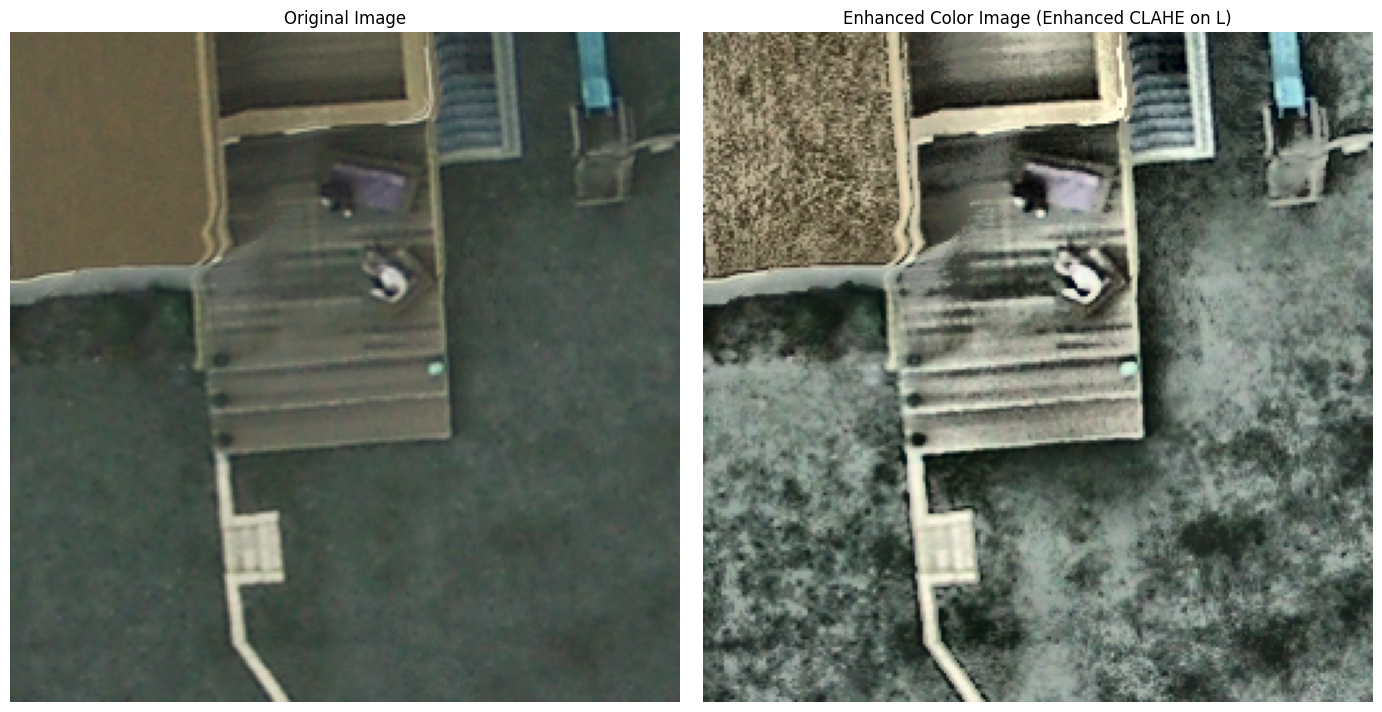

Enhanced image saved as 'enhanced_color_image_enhanced.png'
End time: 367.689966582
Elapsed time: 1.0712 seconds


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2  # Import OpenCV for image loading and color conversion

# Assuming EnhancedPyTorchOCLAHE class is defined in your code

def getLuminanceLayer(image_bgr):
    lab_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    return l_channel, a_channel, b_channel

def getRGBfromLAB(l, a, b):
    lab_image = cv2.merge((l.astype(np.uint8), a.astype(np.uint8), b.astype(np.uint8)))
    bgr_image_reconstructed = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    return bgr_image_reconstructed


# Example 3: Using a True image loaded in First10Images[300]
def example_with_custom_image_enhanced(image):
    sample = image  # True color image loaded in First10Images[300]

    # Convert to LAB color space to work on the Luminance channel
    Luminance_Layer, a_channel, b_channel = getLuminanceLayer(sample)

    # Create EnhancedPyTorchOCLAHE processor
    clahe = EnhancedPyTorchOCLAHE(use_gpu=True, target_tile_size=(32, 32)) # You can adjust tile size
    
    # Apply the enhanced CLAHE to the Luminance layer
    enhanced_Luminance = clahe.apply(Luminance_Layer, verbose=True)

    # Merge the enhanced Luminance layer back with the a and b channels
    enhanced_bgr = getRGBfromLAB(enhanced_Luminance, a_channel, b_channel)

    # Visualize results
    visualize_enhancement(image, enhanced_bgr, "Enhanced Color Image (Enhanced CLAHE on L)")

    # Save the enhanced image
    cv2.imwrite('enhanced_color_image_enhanced.png', enhanced_bgr)
    print("Enhanced image saved as 'enhanced_color_image_enhanced.png'")

# Assume First10Images is a list or array containing loaded images
# For demonstration, let's create a dummy First10Images
if __name__ == "__main__":
    start_time = time.perf_counter()
    print(f"Start time: {start_time}")

    # Create a dummy First10Images for demonstration
    f = First10Images[300]

    # Ensure First10Images[300] is within the bounds of the list
    if 0 <= 300 < len(First10Images):
        example_with_custom_image_enhanced(First10Images[300])
    else:
        print("Error: Index 300 is out of bounds for First10Images.")

    end_time = time.perf_counter()
    print(f"End time: {end_time}")

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")